### Step 1: Import Libraries

In [1]:
import os
import joblib
import numpy as np

import cv2
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load and preprocess the fish dataset

In [2]:
data_dir = r"D:\VS projects\fish_classifier\Fish_Dataset"

X = []
y = []

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)

    # skip GT folders
    if not os.path.isdir(class_folder) or class_name.endswith("GT"):
        continue
    
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        try:
            img = imread(img_path)   # load image
            img = resize(img, (128,128), anti_aliasing=True)
            X.append(img)            # append image as is
            y.append(class_name)     # append label
        except:
            print("Error loading:", img_path)



X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)   # (num_samples, H, W)
print("y shape:", y.shape)   # (num_samples,)

X shape: (9000, 128, 128, 3)
y shape: (9000,)


### Step 3: Split Dataset

In [3]:
X_train, X_v, y_train, y_v = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Step 4: Load Base Models

In [4]:
#load the pretrained models
device = 'cpu' 

print("Loading HOG+ANN Model...")
ann_model = load_model('best_ann_model.h5') 

cnn_model = load_model('best_model_cnn.h5') 
print("CNN Loaded.")

mobilenet_model = load_model('MobileNetV2_fold01_model.h5') 
print("MobileNet Loaded.")

Loading HOG+ANN Model...


CNN Loaded.


MobileNet Loaded.


### Step 5: HOG Feature function

In [5]:
def get_single_hog_features(img_np):
    if img_np.max() > 1.0:
        img_norm = img_np / 255.0
    else:
        img_norm = img_np

    feature = hog(img_norm, orientations=9, pixels_per_cell=(8, 8),
                  cells_per_block=(2, 2), visualize=False, channel_axis=-1)
    
    return feature.reshape(1, -1)

### Step 6: Generate Meta-Features

In [6]:
meta_X = []
meta_y = []
classes_count = 9

print(f"Generating predictions for {len(X_train)} validation images...")

for i in range(len(X_train)):
    
    # Get image and label
    img = X_train[i]   
    label = y_train[i]
    
    # --- ANN (HOG) ---
    hog_feats = get_single_hog_features(img)
    pred_ann = ann_model.predict(hog_feats, verbose=0)[0]

    # Safe Normalization 
    if img.max() > 1.0:
        img_keras = img.astype('float32') / 255.0
    else:
        img_keras = img.astype('float32')
        
    # Add Batch Dimension
    img_batch = np.expand_dims(img_keras, axis=0)

    # Keras .predict returns numpy array directly
    pred_cnn = cnn_model.predict(img_batch, verbose=0)[0]
    pred_mobile = mobilenet_model.predict(img_batch, verbose=0)[0]

    # --- COMBINE & STORE ---
    stacked_features = np.concatenate([pred_ann, pred_cnn, pred_mobile])
    
    meta_X.append(stacked_features)
    meta_y.append(label)

# Convert to final arrays
meta_X = np.array(meta_X)
meta_y = np.array(meta_y)

print(f"Meta-Training Data Ready: Shape {meta_X.shape}")

Generating predictions for 7200 validation images...
Meta-Training Data Ready: Shape (7200, 27)


### Step 7: Train the Meta-Learner

In [7]:
print("Training Fusion Model...")
meta_model = LogisticRegression()
meta_model.fit(meta_X, meta_y)

joblib.dump(meta_model, 'fusion_manager_model.pkl')

Training Fusion Model...


['fusion_manager_model.pkl']

### Step 8: Evaluate & Visualize

In [9]:
meta_X = []
meta_y = []
classes_count = 9

print(f"Generating predictions for {len(X_v)} validation images...")

for i in range(len(X_v)):
    
    # Get image and label
    img = X_v[i]   
    label = y_v[i]
    
    # --- ANN (HOG) ---
    hog_feats = get_single_hog_features(img)
    pred_ann = ann_model.predict(hog_feats, verbose=0)[0]

    # Safe Normalization 
    if img.max() > 1.0:
        img_keras = img.astype('float32') / 255.0
    else:
        img_keras = img.astype('float32')
        
    # Add Batch Dimension
    img_batch = np.expand_dims(img_keras, axis=0)

    # Keras .predict returns numpy array directly
    pred_cnn = cnn_model.predict(img_batch, verbose=0)[0]
    pred_mobile = mobilenet_model.predict(img_batch, verbose=0)[0]

    # --- COMBINE & STORE ---
    stacked_features = np.concatenate([pred_ann, pred_cnn, pred_mobile])
    
    meta_X.append(stacked_features)
    meta_y.append(label)

# Convert to final arrays
meta_X_val = np.array(meta_X)
meta_y_val = np.array(meta_y)

print(f"Meta-Training Data Ready: Shape {meta_X_val.shape}")

Generating predictions for 1800 validation images...
Meta-Training Data Ready: Shape (1800, 27)


Fusion Model is making decisions...
🚀 FUSION MODEL ACCURACY: 100.00%

Classification Report:

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       200
   Gilt-Head Bream       1.00      1.00      1.00       200
   Hourse Mackerel       1.00      1.00      1.00       200
        Red Mullet       1.00      1.00      1.00       200
     Red Sea Bream       1.00      1.00      1.00       200
          Sea Bass       1.00      1.00      1.00       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       1.00      1.00      1.00       200
             Trout       1.00      1.00      1.00       200

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



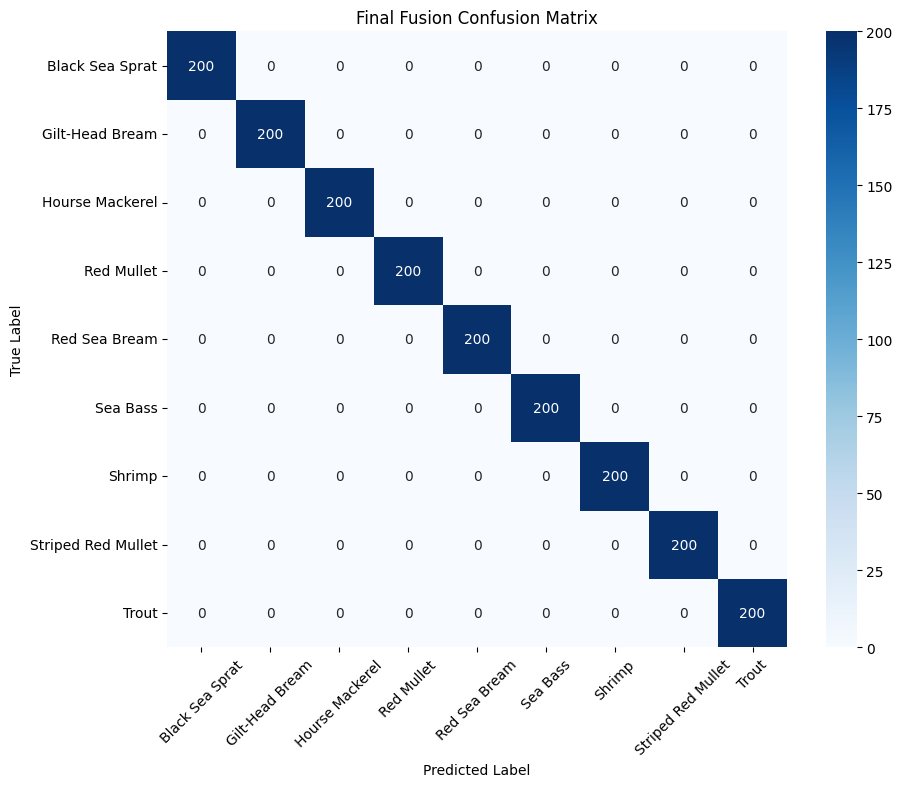

In [10]:
# make predictions
print("Fusion Model is making decisions...")
final_predictions = meta_model.predict(meta_X_val)

#Calculate Final Accuracy
fusion_acc = accuracy_score(meta_y_val, final_predictions)
print(f"==========================================")
print(f"🚀 FUSION MODEL ACCURACY: {fusion_acc*100:.2f}%")
print(f"==========================================")

# Show Detailed Report
print("\nClassification Report:\n")
print(classification_report(meta_y_val, final_predictions))

# 4. Plot Confusion Matrix
plt.figure(figsize=(10, 8))
# Get unique class names from the data for the axis labels
class_names = sorted(list(set(meta_y_val)))
cm = confusion_matrix(meta_y_val, final_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Final Fusion Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()